# Milestone 2 Topic Trending Analysis
Nowadays, the media is full of overwhelming information in different topics and different areas. Although large amount of data is helpful in big data mining, most of data is not meaningful to us. In order to extract meaningful information from a large dataset which contains millions of quotations, trending topic analysis is a Natural Language Processing (NLP) technique that allows us to automatically extract meaningful information from text by identifying recurrent themes or topics. Hot topic analysis can help providing many meaningful information to be used in many recommendataion system, for example, social media monitoring tools and marketing.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
import pandas as pd
import re
from functools import reduce
from string import punctuation
import matplotlib.pyplot as plt
from itertools import chain
%matplotlib inline  

from sklearn.feature_extraction.text import TfidfVectorizer

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Phrases
from gensim import models
from gensim import corpora
from gensim.models import CoherenceModel
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from tqdm.notebook import tqdm
tqdm.pandas(desc="progress-bar")

[nltk_data] Downloading package punkt to /home/shanci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/shanci/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/shanci/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/shanci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the dataset
We use the quote-2019.json and load it using chunksize 1000000. In total, we get the 22 chunks and aggregate the chunks by the date. 
After that, we combine these 22 chunks to get a single dataframe with shape 365*2. One column is the date(by day), the other are all the quotations from the single day.

In [ ]:
filename = '/media/shanci/DataDisk/ada_quotebank/quotes-2019.json.bz2' 

def process_chunk(chunk, idx):
    chunk['date'] = chunk.date.apply(lambda x: x.date())  
    transformed = chunk.groupby('date')['quotation'].apply(lambda x:x.str.cat(sep=' ')).reset_index()
        
    transformed.to_json('/media/shanci/DataDisk/ada_quotebank/chunk_{}.json'.format(idx))

with pd.read_json(filename, lines=True, compression='bz2', chunksize=1000000) as df_reader:
    for idx, chunk in enumerate(df_reader):
        process_chunk(chunk, idx)

In [ ]:
fileroot = '/media/shanci/DataDisk/ada_quotebank/' 
json_list = []
for i in range(22):
    json = pd.read_json(fileroot + "chunk_{}.json".format(i))
    json_list.append(json)
    

In [ ]:
total_json = pd.concat(json_list)
data = total_json.groupby('date')['quotation'].apply(lambda x:x.str.cat(sep=' ')).reset_index()
data.head()

## Here we load the 5 days data to present in this demo

In [2]:
data = pd.read_json('five_days.json')
data.head()

,date,quotation
0,2019-01-01,"actually embarrassed for the governor, Most le..."
1,2019-01-02,a major step in improving our footing in Latin...
2,2019-01-03,"always willing to help her coworkers, no matte..."
3,2019-01-04,A Pile of Leaves. All my customers aren't work...
4,2019-01-05,It's turning into this foodie community and th...


## Build Tokenizer
Here we build a tokenizer. This will, for every quotation:
1. lowercase the text and clean it (separate function)
2. break the descriptions into sentences and then break the sentences into tokens
3. remove punctuation, stop words
The first step is done by the clean_text function defined below.

Tokenization is a process to seprate the sentences into single words and punctuations.The second step is done by sent_tokenize from nltk.tokenize and word_tokenize from nltk.tokenize.

Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc. We have adopted stopwords file from https://github.com/ahmedbesbes/How-to-mine-newsfeed-data-and-extract-interactive-insights-in-Python/blob/master/data/stopwords.txt. We also add the stopword from nltk.corpus. Here you can also add your stopword into the additional_stop_words list.

In [3]:
# They remove non ascii characters and standardize the text (can't -> cannot, i'm -> i am). This will make the tokenization process more efficient.
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

In [4]:
stop_words = []

# load the stopwords file 
f = open('stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))

# interface for adding words to the stop_words list
additional_stop_words = ['t', 'will']
stop_words =  stop_words + additional_stop_words + stopwords.words('english')
print("The total stopword is {}".format(len(stop_words)))

The total stopword is 847


In [5]:
def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

In [6]:
data['tokens'] = data['quotation'].progress_map(lambda d: tokenizer(d))

progress-bar:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
data

,date,quotation,tokens
0,2019-01-01,"actually embarrassed for the governor, Most le...","[embarrassed, governor, lenders, treat, regula..."
1,2019-01-02,a major step in improving our footing in Latin...,"[major, step, improving, footing, latin, ameri..."
2,2019-01-03,"always willing to help her coworkers, no matte...","[help, coworkers, matter, busy, displays, prof..."
3,2019-01-04,A Pile of Leaves. All my customers aren't work...,"[pile, leaves, customers, working, people, ski..."
4,2019-01-05,It's turning into this foodie community and th...,"[turning, foodie, community, wanted, fabric, g..."


## Part of Speech Tagging and Lemmatization
Lemmatisation is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. Unlike stemming, lemmatisation depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document.

Generally, lemmatization is followed by Part of Speech Tagging (POS-Tag), which is the labeling of the words in a text according to their word types (noun, adjective, adverb, verb, etc.) POS tagging is a supervised learning solution that uses features like the previous word, next word, is first letter capitalized etc. NLTK has a function to get pos tags and it works after tokenization process. Detailed tags can be found here(https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

NLTK provides WordNetLemmatizer class which is a thin wrapper around the wordnet corpus.

In [8]:
data['POS_tokens'] = data['tokens'].progress_map(lambda tokens: pos_tag(tokens))

progress-bar:   0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

lemmatizer = WordNetLemmatizer()
data['tokens_after_lemmatized'] = data['POS_tokens'].progress_map(
    lambda list_tokens_POS:
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in list_tokens_POS
        ] 
        
)

progress-bar:   0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
data

,date,quotation,tokens,POS_tokens,tokens_after_lemmatized
0,2019-01-01,"actually embarrassed for the governor, Most le...","[embarrassed, governor, lenders, treat, regula...","[(embarrassed, VBN), (governor, NN), (lenders,...","[embarrass, governor, lender, treat, regulatio..."
1,2019-01-02,a major step in improving our footing in Latin...,"[major, step, improving, footing, latin, ameri...","[(major, JJ), (step, NN), (improving, VBG), (f...","[major, step, improve, foot, latin, america, e..."
2,2019-01-03,"always willing to help her coworkers, no matte...","[help, coworkers, matter, busy, displays, prof...","[(help, NN), (coworkers, NNS), (matter, RBR), ...","[help, coworkers, matter, busy, display, profe..."
3,2019-01-04,A Pile of Leaves. All my customers aren't work...,"[pile, leaves, customers, working, people, ski...","[(pile, NN), (leaves, VBZ), (customers, NNS), ...","[pile, leave, customer, work, people, skill, c..."
4,2019-01-05,It's turning into this foodie community and th...,"[turning, foodie, community, wanted, fabric, g...","[(turning, VBG), (foodie, JJ), (community, NN)...","[turn, foodie, community, want, fabric, grow, ..."


## Phrase detection
We need to automatically detect common phrases like multi-word expressions, word n-gram collocations from a stream of tokens. Here we use bigram and trigram

In [11]:
tokens = data['tokens_after_lemmatized'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

## Create the dictionary
In Gensim, the dictionary object is used to create a bag of words (BoW) corpus which further used as the input to topic modelling and other models as well.

Corpus − It refers to a collection of documents as a bag of words (BoW).

Here we define three functions:
1. LDA_model, this function returns the LDA model
2. compute_coherence, this function is used to compute coherence score to evaluate the LDA model
3. display_topics, function to display topics and corresponding keywords:
3. explore model. this is a tuning function, used to explore different topics of LDA models.

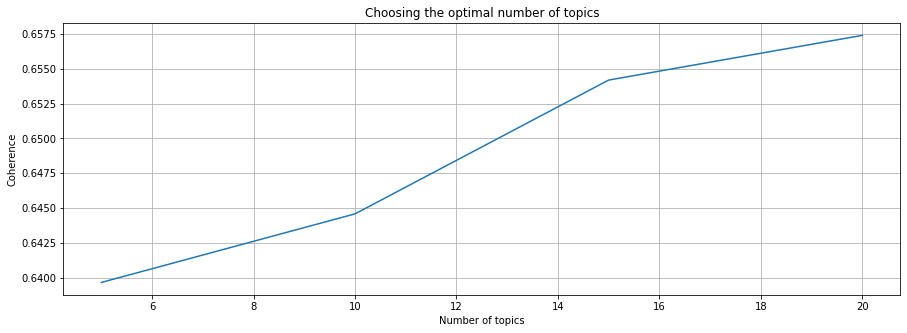

In [12]:
dict_LDA = corpora.Dictionary(tokens)
dict_LDA.filter_extremes(no_below=1)
corpus = [dict_LDA.doc2bow(tok) for tok in tokens]

def LDA_model(num_topics,corpus, id2word, passes=1):
    return gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               eval_every=10,
                                               chunksize=2000,
                                               passes=passes,
                                               per_word_topics=True
                                            )
def compute_coherence(model,tokens, id2word):
    coherence = CoherenceModel(model=model, 
                           texts=tokens,
                           dictionary=id2word, coherence='c_v')
    return coherence.get_coherence()

def display_topics(model, num_words=10):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=num_words)
    topics = map(lambda c: map(lambda cc: cc[0], c[1]), topics)
    df = pd.DataFrame(topics)
    df.index = ['topic_{0}'.format(i) for i in range(model.num_topics)]
    df.columns = ['keyword_{0}'.format(i) for i in range(1, num_words+1)]
    return df

def explore_models(corpus, id2word, tokens, rg=range(5, 25)):
    models = []
    coherences = []
    
    for num_topics in rg:
        lda_model = LDA_model(num_topics,corpus, id2word, passes=5)
        models.append(lda_model)
        coherence = compute_coherence(lda_model, tokens, id2word)
        coherences.append(coherence)
      

    fig = plt.figure(figsize=(15, 5))
    plt.title('Choosing the optimal number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.grid(True)
    plt.plot(rg, coherences)
    
    return coherences, models


coherences, models = explore_models(corpus, dict_LDA, tokens, rg=range(5, 25,5))

From the above graph, we can get that the best model has 20 topics

In [13]:
best_model = LDA_model(num_topics=20, corpus=corpus, id2word=dict_LDA, passes=5)

display_topics(model=best_model, num_words=10)

,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9,keyword_10
topic_0,call_national_emergency_build,love_support_olivia,go_go_impeach,son_momma_bully_win,son_mama_bully_win,call_shutdown,motherf_er,market_edition,heck_lot_company,call_national_emergency_security
topic_1,market_edition,illness_slip_coma_afternoon,newton_john_cancer_wellness,call_national_emergency_build,aadhaar,love_support_olivia,pm_canadian_time_prolong,dad_leave_passed_december,heck_lot_company,clear_russian_expectation_learn
topic_2,korowai,career_basketball,oklahoma_city_thunder_guard,kejriwal,game_portland_ore_friday,call_national_emergency_build,ap_photo_craig_mitchelldyer,team_win_lunatic,reason_wear,portland_ore_friday_jan
topic_3,call_national_emergency_build,market_edition,love_host_oscar,love_support_olivia,go_go_impeach,heck_lot_company,republican_path,son_mama_bully_win,aadhaar,test_cricket_vital
topic_4,market_edition,call_national_emergency_build,go_go_impeach,son_momma_bully_win,love_support_olivia,heck_lot_company,market_send,galway,call_national_emergency_security,son_mama_bully_win
topic_5,market_edition,week_reach_agreement,test_cricket_vital,entire_era,punjab_club,defence_minister_hide_aiadmk,quantum_science_technology,revelation_khashoggi_kill_shatter,denishar,aitchison
topic_6,market_edition,call_national_emergency_build,illness_slip_coma_afternoon,call_national_emergency_security,test_cricket_vital,president_open_government,support_week_stance,inbetweeners,ultima,clear_russian_expectation_learn
topic_7,call_national_emergency_build,market_edition,call_national_emergency_security,call_shutdown,heck_lot_company,tax_rate_high,son_mama_bully_win,son_momma_bully_win,newton_john_cancer_wellness,go_go_impeach
topic_8,call_national_emergency_build,galway,market_edition,go_go_impeach,love_host_oscar,son_mama_bully_win,heck_lot_company,call_shutdown,motherf_er,people_loud_huge
topic_9,market_edition,imelda,test_cricket_vital,clear_russian_expectation_learn,people_natural_dislike,reality_clear,achieve_sport,appropriate_demand_return,inbetweeners,aphorism


Now let's build a document/topic matrix. The element (i,j) of the matrix shows the importance of topic j in the day i, since we integrate all the quotations in one day as a document.

In [14]:
def get_document_topic_matrix(corpus, num_topics=best_model.num_topics):
    matrix = []
    for row in tqdm(corpus):
        output = np.zeros(num_topics)
        doc_proba = best_model[row][0]
        for doc, proba in doc_proba:
            output[doc] = proba
        matrix.append(output)
    matrix = np.array(matrix)
    return matrix

matrix = get_document_topic_matrix(corpus)

  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
matrix

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.99996543, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.23633955, 0.        , 0.        , 0.        , 0.76364237,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.0223309 ,
        0.        , 0.        , 0.06537685, 0.        , 0.        ,
        0.        , 0.91219842, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.3311471 , 0.66882914, 0

## NMF: Non-negative Matrix Factorization  
  
This is a small section where we show that a popular technique based on linear algebra can work as well for topic modeling.

In [16]:
from sklearn.decomposition import NMF

vectorizer = TfidfVectorizer(min_df=3, analyzer='word', ngram_range=(1, 3), stop_words='english')
vz = vectorizer.fit_transform(list(data['tokens_after_lemmatized'].map(lambda tokens: ' '.join(tokens))))

nmf = NMF(n_components=2, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(vz)

feature_names = vectorizer.get_feature_names()
no_top_words = 10

for topic_idx, topic in enumerate(nmf.components_[:10]):
    print("Topic %d:"% (topic_idx))
    print(" | ".join([feature_names[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]))

Topic 0:
people | year | time | good | work | play | thing | game | lot | team
Topic 1:
zur | game competition | game complete | game completely | game concede | game concentrate | game condition | game conference | game confidence | game confident


## Visualization of LDA model

In [17]:
vis = pyLDAvis.gensim_models.prepare(topic_model=best_model, corpus=corpus, dictionary=dict_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

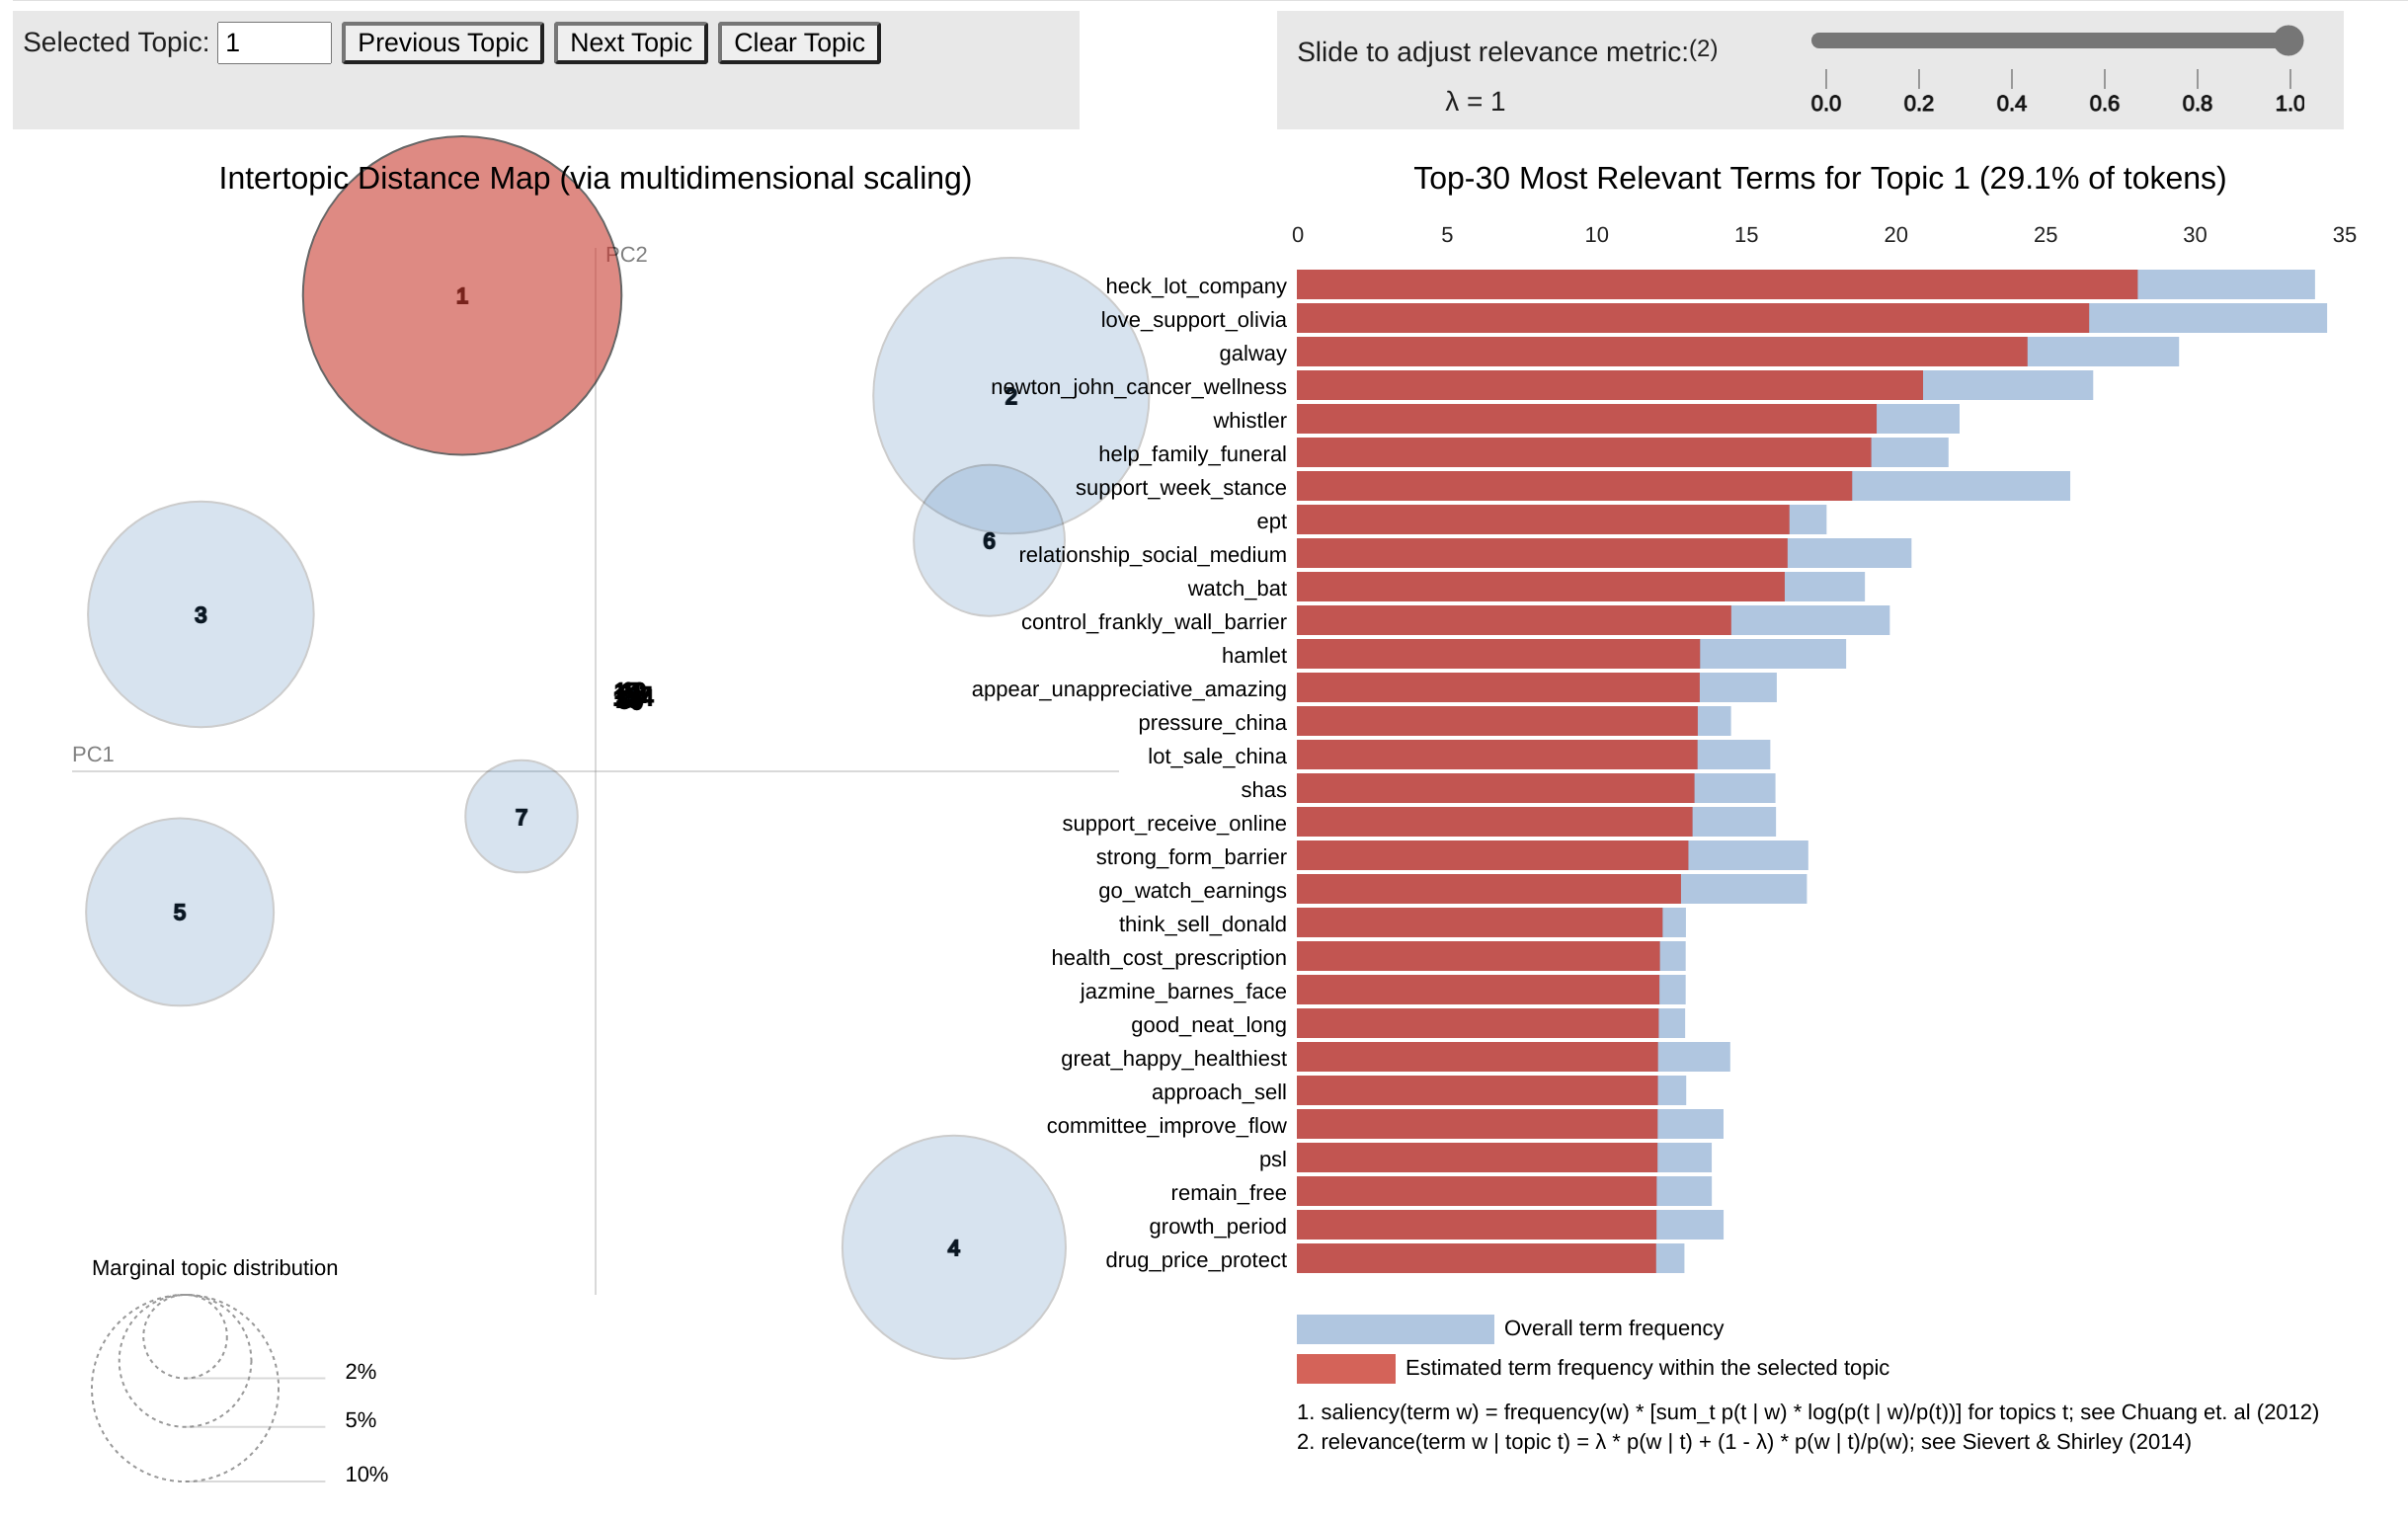

In [18]:
# show the screenshot of interactive plot
from IPython.display import Image
Image('2021-11-12_22-39.png')

## TF-IDF Matrix
TF-IDF stands for term frequencey-inverse document frequency. It's a numerical statistic intended to reflect how important a word is to a document or a corpus (i.e a collection of documents).

To relate to this post, words correpond to tokens and documents correpond to descriptions. A corpus is therefore a collection of descriptions.

In [19]:
vectorizer = TfidfVectorizer(min_df=2, analyzer='word', ngram_range=(1, 3), stop_words='english')
vz = vectorizer.fit_transform(list(data['tokens_after_lemmatized'].map(lambda tokens: ' '.join(tokens))))
print(vz.shape)

(5, 316308)


vz is a tfidf matrix.

its number of rows is the total number of documents (descriptions)

its number of columns is the total number of unique terms (tokens) across the documents (descriptions)

<AxesSubplot:>

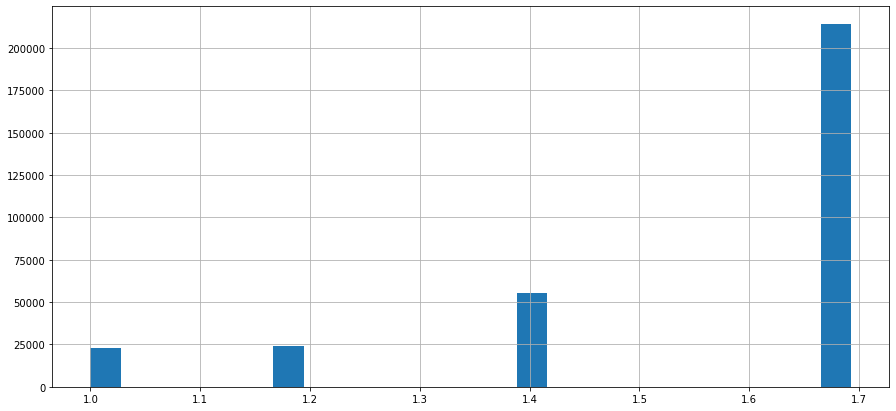

In [20]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

tfidf.tfidf.hist(bins=25, figsize=(15,7))

## WordCloud to visialise words
We can use wordcloud to display important word and unimportant world.

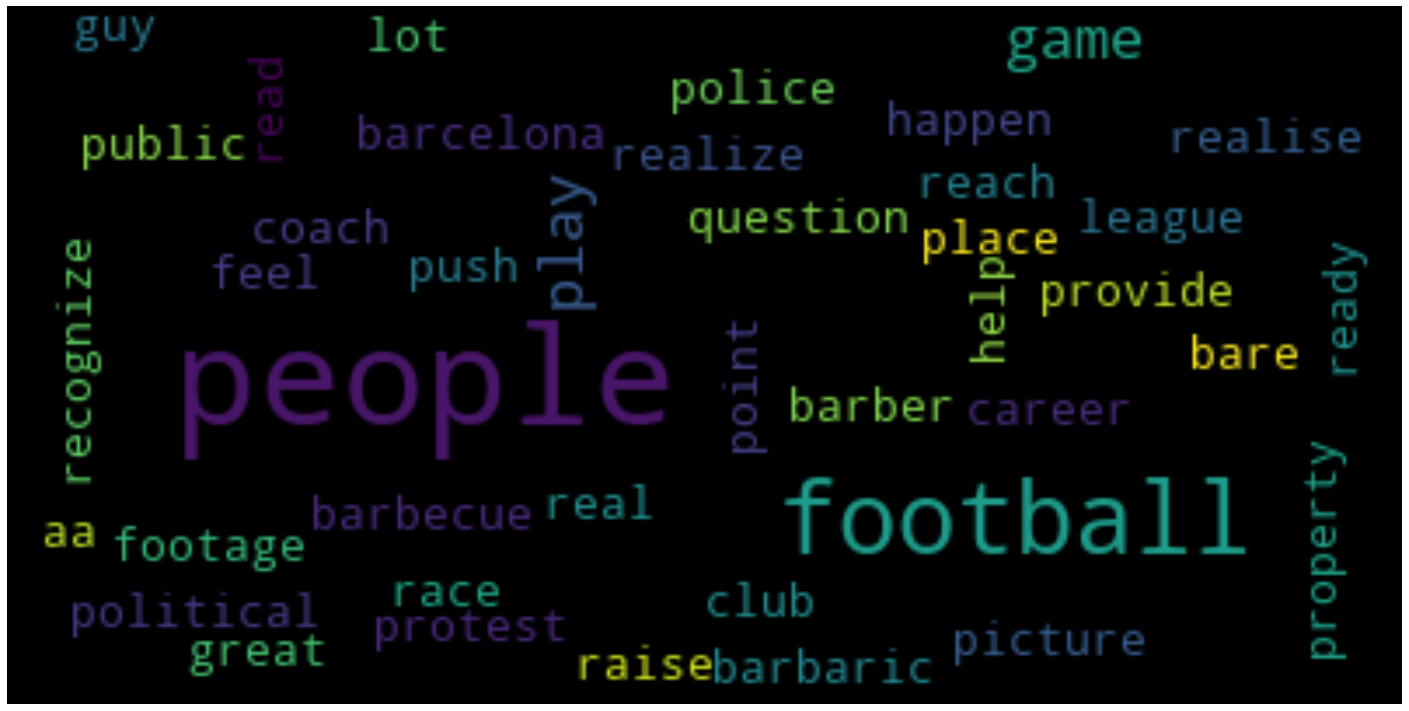

In [21]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=True).head(40))

we end up with a list of very generic words. These are very common across many descriptions. tfidf attributes a low score to them as a penalty for not being relevant. Words likes people, lot, aa, etc...

Now let's check out the 40 words with the highest tfidf scores.

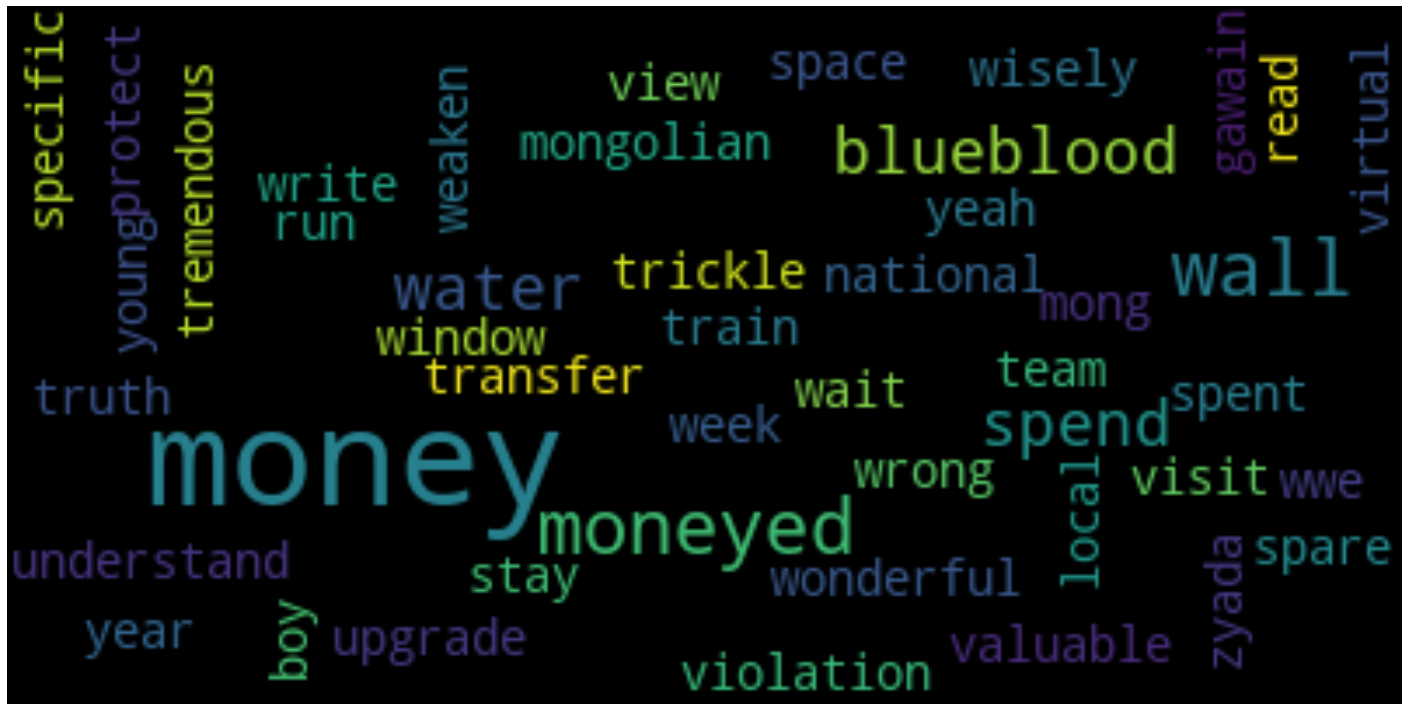

In [22]:
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=False).head(40))

We end up with less common words. These words naturally carry more meaning for the given description and may outline the underlying topic.

# Summary  

As the initial analysis above, we show the feasibility of implement LDA and topic modeling with the TF-ITF matrix and other method. With the topic vector we extract from the document of all the quotations from one day, we can go back to each quotation and classify them by calculating their distance to the topic vector. Then we can extract sentiment and perform analysis on the topic trend and the sentiment.
